In [1]:
%matplotlib inline
%env OMP_NUM_THREADS=10
%pylab inline
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 12]

import cv2
from matplotlib.colors import LinearSegmentedColormap

from typing import List
import random

env: OMP_NUM_THREADS=10
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import g2o

In [3]:
class VertexEclipse(g2o.VectorXVertex):
    """A circle parameterized by position x,y with radius a,b """

    def __init__(self) -> None:
        g2o.VectorXVertex.__init__(self)
        self.set_dimension(4)
        self.set_estimate([0] * 4)

    def oplus_impl(self, update) -> None:
        self.set_estimate(self.estimate() + update)
       
class VertexTheta(g2o.VectorXVertex):
    """A angle of point on eclipse parameterized by theta """

    def __init__(self) -> None:
        g2o.VectorXVertex.__init__(self)
        self.set_dimension(1)
        self.set_estimate([0])

    def oplus_impl(self, update) -> None:
        self.set_estimate(self.estimate() + update)
    
class EdgePointOnEclipse(g2o.VariableVectorXEdge):
    def __init__(self) -> None:
        g2o.VariableVectorXEdge.__init__(self)
        self.set_dimension(1)  # dimension of the error function
        self.information()
        self.resize(2)  # number of vertices
        self.set_measurement([0, 0])  # initial measurement

    def compute_error(self):
        eclipse = self.vertex(0).estimate()
        theta = self.vertex(1).estimate()
        
        cx = eclipse[0]
        cy = eclipse[1]
        
        a = eclipse[2]
        b = eclipse[3]
        estimate = np.array([a * np.cos(theta) + cx, b * np.sin(theta) + cy])
        
        error = np.linalg.norm(self.measurement() -  estimate)
        return [error]

In [4]:
num_points: int = 100
max_iterations: int = 10
verbose: bool = True
# TODO: Parse from command line

# Setup the optimizer
optimizer = g2o.SparseOptimizer()
solver = g2o.BlockSolverSE3(g2o.LinearSolverDenseSE3())
solver = g2o.OptimizationAlgorithmLevenberg(solver)
optimizer.set_algorithm(solver)

In [5]:
# generate random data
center: np.ndarray = np.array([4.0, 2.0])
A: float = 2.0
B: float = 10
points: List[np.array] = []

for _ in range(num_points):
    a = random.gauss(A, 0.05)
    b = a * B/A
    angle = random.uniform(0.0, 2.0 * np.pi)
    points.append(center + np.array([a * np.cos(angle), b * np.sin(angle)]))

In [6]:
eclipse: VertexEclipse = VertexEclipse()
eclipse.set_id(0)
eclipse.set_estimate([3.0, 3.0, 3.0])  # some initial value for the circle
optimizer.add_vertex(eclipse)

True

In [7]:
# 2. add the points we measured
for i,point in enumerate(points,1):
    
    theta: VertexTheta = VertexTheta()
    theta.set_id(i)
    theta.set_estimate([0])
    
    optimizer.add_vertex(theta)

    edge: EdgePointOnEclipse = EdgePointOnEclipse()
    edge.set_information(np.identity(1))
  
    edge.set_vertex(0, eclipse)
    edge.set_vertex(1, theta)

    edge.set_measurement(point)
    # print(f"error: {edge.compute_error()}")
    # print(f"edge slots: {dir(edge)}")
    optimizer.add_edge(edge)

In [8]:
print(f"Number of vertices: {len(optimizer.vertices())}")
print(f"Number of edges: {len(optimizer.edges())}")

Number of vertices: 101
Number of edges: 100


In [9]:
# perform the optimization
optimizer.initialize_optimization()
optimizer.set_verbose(verbose)
optimizer.optimize(max_iterations)

IndexError: index 3 is out of bounds for axis 0 with size 3

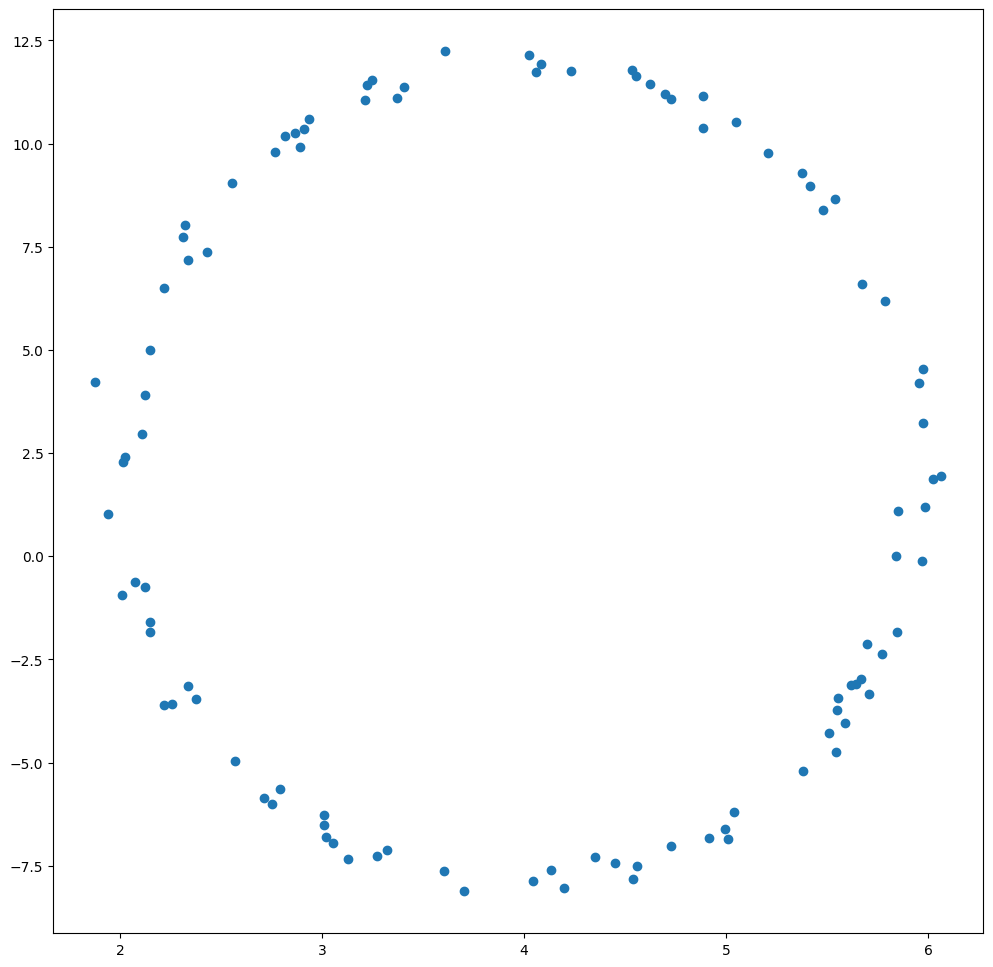

In [43]:
dd = np.array(points).T
plt.scatter(dd[0,:],dd[1,:])

In [38]:
dd.shape

(2, 100)